In [1]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)
    
    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))
    
    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])
    
    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

In [3]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

# Use wget to download the file
wget.download(url, out=filename)
print('file downloaded')

file downloaded


In [4]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    # Split the text into paragraphs (simple split by newline characters)
    paragraphs = text.split('\n')
    # Filter out any empty paragraphs or undesired entries
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:10]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

In [5]:
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )

sample: 0 paragraph: 1.	Code of Conduct 

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



In [6]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [7]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


In [8]:
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


In [10]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
#shuffling samples so that the samples are not ordered based on the category they belong to
random.shuffle(paragraphs)

In [12]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256) 
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.3869,  0.4322,  0.3379,  ..., -0.4071, -0.0797, -0.0184],
        [ 0.3496,  0.0343, -0.1212,  ..., -0.1398, -0.5199,  0.0581],
        [ 0.7075,  0.6072,  0.0172,  ..., -0.1247,  0.4195, -0.4397],
        ...,
        [ 0.6261, -0.1179, -0.0610,  ...,  0.0211, -0.0856,  0.1127],
        [ 0.4441,  0.3670, -0.0401,  ..., -0.3736, -0.1618, -0.1306],
        [ 0.3005,  0.5121, -0.1546,  ..., -0.7096, -0.9071,  0.2282]],
       grad_fn=<SliceBackward0>)

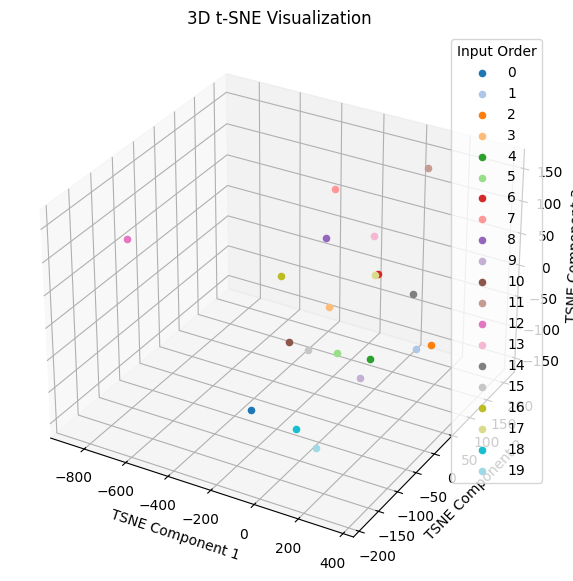

In [13]:
tsne_plot(outputs.pooler_output.detach().numpy())

In [14]:
print("sample 16:", paragraphs[16])

sample 16: Treatment and Assistance: Employees with substance abuse issues are encouraged to seek help. The organization is committed to providing support, resources, and information to assist those seeking treatment.


In [15]:
print("sample 12:", paragraphs[12])

sample 12: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.


In [16]:
embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [17]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

In [18]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

In [19]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index

In [20]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# Example question
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
D, I = index.search(question_embedding, k=5)  # Retrieve top 5 relevant contexts
print("D:",D)
print("I:",I)

D: [[72.765335 74.7162   84.38811  88.364365 90.28708 ]]
I: [[50 29 65 45 15]]


In [22]:
print("Top 5 relevant contexts:")
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")

Top 5 relevant contexts:
1: 6.	Drug and Alcohol Policy
distance 72.76533508300781

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71620178222656

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38810729980469

4: 9.	Discipline and Termination Policy
distance 88.36436462402344

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.28707885742188



In [23]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

In [24]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [25]:
contexts= "What is a large language model?"

In [26]:
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [27]:
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

In [28]:
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


In [29]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)
    
    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    
    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [30]:
# Example usage
question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


In [31]:
def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [32]:
question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

paragraphs indexs [[24 44 15 35 55]]


In [33]:
top_contexts = [paragraphs[idx] for idx in I[0]] 
print(f"top_contexts {top_contexts}")

top_contexts ['4.\tMobile Phone Policy', 'The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance.', 'Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.']


In [34]:
# Assume `I[0]` contains indices of top contexts from the retrieval step
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

Generated Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the sta